## Explain Your Model with the SHAP Values

* Please read [Explain your model with the SHAP values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

In [1]:
import pandas as pd
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt


In [6]:
df = pd.read_csv('loan_default.csv') # ,sep=';')

In [7]:
df.shape

(80000, 89)

In [8]:
df.head()

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,2,3,3,0,33,1,4,12,2017/7/1 14:11,h5,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,3,4,4,0,34,2,4,12,2017/7/7 10:10,android,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,4,5,5,0,47,2,1,12,2017/7/6 14:37,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


In [41]:
df.PA031.value_counts()

-98.000000     56004
-99.000000      1534
 0.000000        198
 23.000000       193
 20.000000       169
               ...  
 234.333333        1
 234.666667        1
 99.400000         1
 306.800000        1
 86.769231         1
Name: PA031, Length: 4323, dtype: int64

In [52]:
df['PA031'].fillna(df['PA031'].mode()[0], inplace = True)
print(df.PA031.isnull().sum())


0


After inspecting the variable, there were 310 NAs in total. It seems like the mode is more insightful than the mean to impute. variable key is described as :"AVG_LEN_COLLECTION_CALLS"

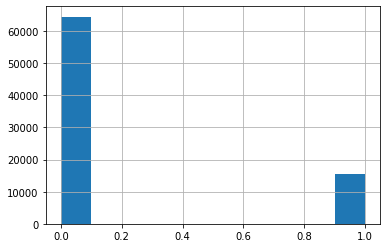

In [9]:
df['loan_default'].hist()

# Data split

In [53]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
df['loan_default'] = df['loan_default'].astype(int)
Y = df['loan_default']
X =  df[['TD013','AP003','TD009','TD005','CR015','TD014','TD010','AP001','TD001','AP007','PA031']]


In [54]:
print(X.isnull().sum())


TD013    0
AP003    0
TD009    0
TD005    0
CR015    0
TD014    0
TD010    0
AP001    0
TD001    0
AP007    0
PA031    0
dtype: int64


No missing values, model is good to go

In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [59]:
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)  
print(model.feature_importances_)

[0.33307949 0.20700786 0.09547447 0.06511256 0.08499939 0.0267585
 0.02073867 0.03151763 0.02627409 0.02075623 0.08828112]


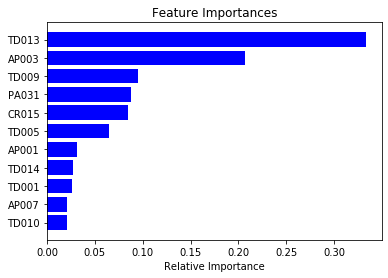

In [60]:
importances = model.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Inspecting variables with sharp

In [16]:
import shap

In [79]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)

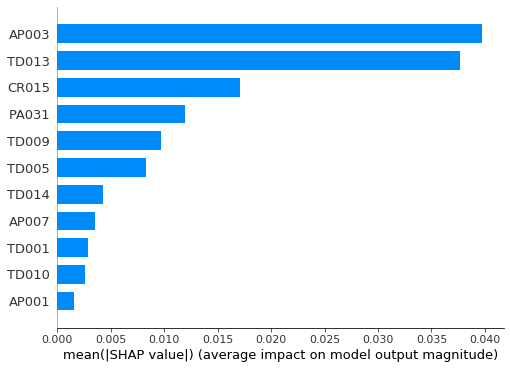

In [80]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Can the above variable importance plot show the directions between the features and the target variable? Yes, that's the power of the Shap value plot as shown below. This plot is made of many dots. Each dot has three characteristics. The graph below plots the SHAP values of every feature for every sample. It shorts features by the total of absolute SHAP values over all samples. The color represents the feature value (red high, blue low). 

* The vertical location shows the feature importance.
* The horizontal location shows whether the effect of that value caused a higher or lower prediction.
* Color shows whether that feature was high or low for that observation

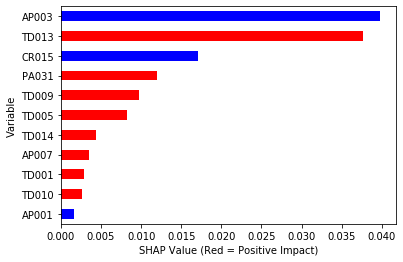

In [81]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(6,4),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train)  

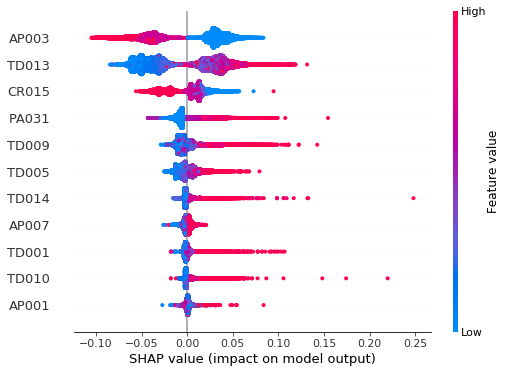

In [82]:
shap.summary_plot(shap_values, X_train)

### Understanding the variables/features

We can describe the model. A high-likehood of default loan is associated with the following characteristics:
* Low AP003- Education 
* High TD0013 - TD_CNT_QUERY_LAST_6MON_P2P
* Low CR015 - MONTH_CREDIT_CARD_MOB_MAX
* High-PA031 - AVG_LEN_COLLECTION_CALLS
* High -AP007 - LEVEL_APPL_CITY
* High- TD014 - TD_CNT_QUERY_LAST_6MON_SMALL_LOAN

1.Low education- increase likehood of default

2.High Query last 6 month p2p, people to people, high frequency of transactions betweens individuals(not business)increase likehood of default

3.Low Month creditcar MOB max- Monthly maximum budget/limit of the credit card, lower the limit- higher chance of default

4.High-PA031 - AVG_LEN_COLLECTION_CALLS- Longer length in collection calls- likely chance to default

5.High -AP007 - LEVEL_APPL_CITY- City of the applicant- system that weights the wealthiness of the city or default rate of the city

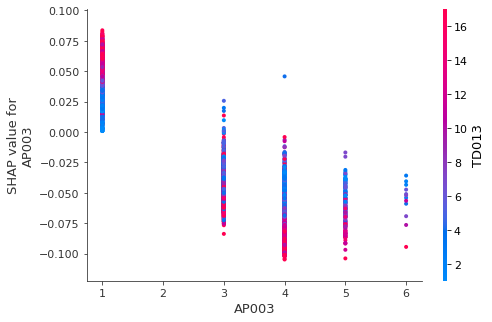

In [83]:
# we pass "Age" instead of an index because dependence_plot() will find it in X's column names for us
# Systolic BP was automatically chosen for coloring based on a potential interaction to check that 
# the interaction is really in the model see SHAP interaction values below
shap.dependence_plot("AP003", shap_values, X_train)

The most interacted variable of AP003 is TD013, there is a negative relationship between these two variables

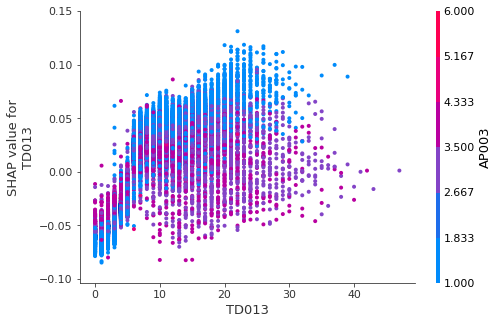

In [66]:
# we pass display_features so we get text display values for sex
shap.dependence_plot("TD013", shap_values, X_train)

The most interacted variable of TD013 is AP003, there is a negative relationship between these two variables


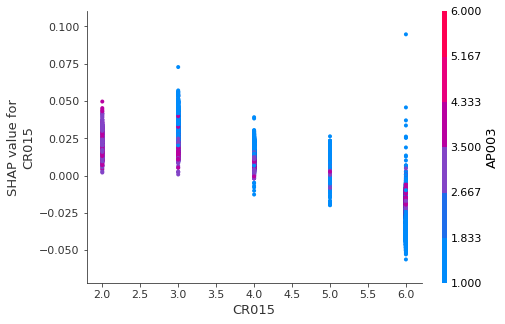

In [87]:
shap.dependence_plot("CR015", shap_values, X_train,show = False)
plt.show()

The most interacted variable of CR015 is AP003, there is a negative relationship between these two variables

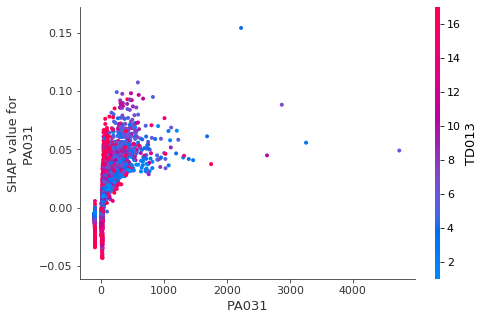

In [67]:
shap.dependence_plot("PA031", shap_values, X_train, show=False)
plt.show()

The most interacted variable of PA031 is TD013, the relationship between these two variables is somewhat mixed

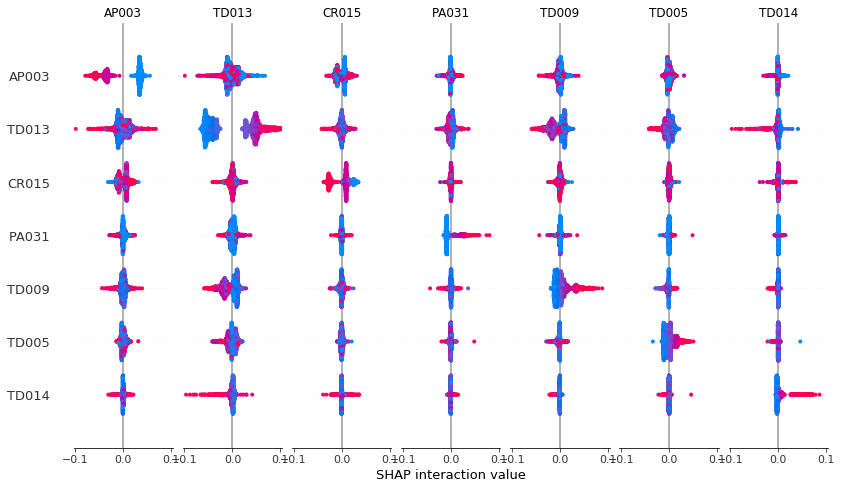

In [68]:

shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_train.iloc[:2000,:])

shap.summary_plot(shap_interaction_values, X_train.iloc[:2000,:])

In [69]:
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)

random_picks = np.arange(1,330,50)
S = X_output.iloc[random_picks]
S

,TD013,AP003,TD009,TD005,CR015,TD014,TD010,AP001,TD001,AP007,PA031,predict
26432,7,1,3,3,6,3,0,35,2,1,55.00,0.21
65202,4,1,2,2,5,1,1,44,1,4,-99.00,0.17
74111,2,1,2,1,6,1,1,31,0,2,21.25,0.11
35688,11,3,11,9,5,1,1,27,4,4,-98.00,0.25
23513,5,3,5,4,5,1,1,27,3,2,83.00,0.15
52749,3,1,3,2,6,1,1,40,2,4,-98.00,0.13
51687,3,1,3,2,6,2,1,41,1,3,-99.00,0.13


In [70]:
shap.initjs()

In [71]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [72]:
X_train.mean()

TD013     6.805906
AP003     2.012750
TD009     5.406031
TD005     3.594516
CR015     4.927141
TD014     2.598453
TD010     2.017875
AP001    31.725656
TD001     1.987453
AP007     3.300391
PA031   -48.491578
dtype: float64

In [73]:
Y_test.mean()

0.19225

In [74]:
shap_plot(0)

In [85]:
shap_plot(1)

In [76]:
shap_plot(2)

In [77]:
shap_plot(3)

In [78]:
shap_plot(4)

Final thoughts: While choosing variables base on variance importance is a good appraoch, when it comes to picking meaningful features to explain the model, we have to consider do we have the ability to explain the variable. For example, date was an important variable chosen by the model however, it does not have much value for the stakeholders as a feature. On the other hand, feature "AP007" is related to location can be applicable for real-life situations to profile different loans and customers. Overall, it's important to have features that explains the large variances of the model. However, we often to have to make a little tradeoffs between variances and usefulness of the feature